In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [2]:
df = pd.read_csv('StatewiseTestingDetails.csv')
df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


### Drop Kolom Yang Tidak Diperlukan

In [3]:
hapus = ['Date', 'State']
df = df.drop(hapus, axis=1)
df.head()

,TotalSamples,Negative,Positive
0,1403.0,1210,12.0
1,2679.0,NaN,27.0
2,2848.0,NaN,33.0
3,3754.0,NaN,33.0
4,6677.0,NaN,33.0


### Mengubah nilai string kosong ' ' pada kolom negative menjadi nilai modus dari kolom Negative
### Menubah tipe data kolom Negative dari string ke float 
### Cleaning nilai Null pada kolom negative menjadi nilai median dari kolom positive
### Kemudian nilai Null pada kolom positive menjadi nilai mean dari kolom positive

In [4]:
df['Negative'] = df['Negative'].replace(' ', df['Negative'].mode()[0])
df['Negative'] = df['Negative'].astype('float64')
df['Negative'].fillna(df['Positive'].median(), inplace=True)
df['Positive'].fillna(df['Positive'].mean(), inplace=True)

print(df.isna().sum())

TotalSamples    0
Negative        0
Positive        0
dtype: int64


### Mengambil data dari dataset ke dalam variabel, kemudian melakukan pemisahan data

In [5]:
X = df[['TotalSamples', 'Negative']]
y = df['Positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### melakukan standarisasi data karena SVR sangat sensitif terhadap skala data

In [6]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))

### Membuat model SVR, kemudian melatih model SVR tersebut dengan data X_train yang telah distandarisasi dengan y_train yang telah distandarisasi

In [7]:
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_scaled.ravel())

SVR(kernel='linear')

### Melakukan prediksi dataset dengan model SVR
### Evaluasi model dengan MAE, MSE, RMSE, dan R-Squared

In [8]:
y_pred = svr.predict(X_test_scaled)

In [9]:
print("MAE :", mean_absolute_error(y_test_scaled, y_pred))
print("MSE :", mean_squared_error(y_test_scaled, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test_scaled, y_pred)))
print("R-Squared :", r2_score(y_test_scaled, y_pred))

MAE : 0.30834611999645156
MSE : 1.0613322041811173
RMSE : 1.0302097864906532
R-Squared : 0.005102949625879538


### Visualisasi SVR
### Titik biru menunjukkan data asli dari dataset dan titik merah menunjukkan hasil predisiksi dari pendekata SVR

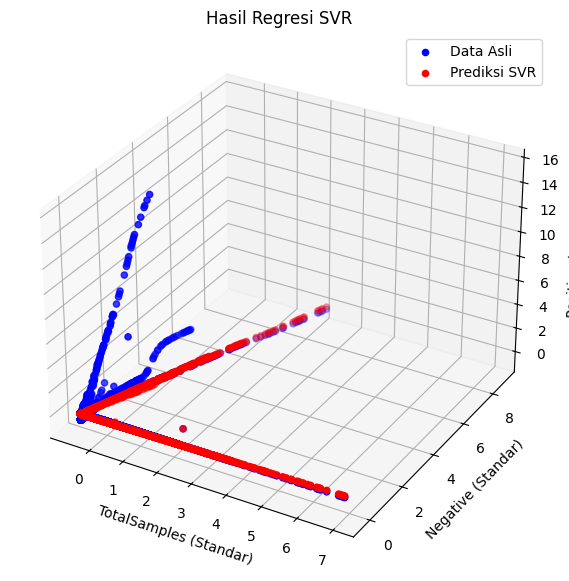

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot data asli
ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_test_scaled, color='b', label='Data Asli')

# Plot hasil prediksi
ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_pred, color='r', label='Prediksi SVR')

ax.set_xlabel('TotalSamples (Standar)')
ax.set_ylabel('Negative (Standar)')
ax.set_zlabel('Positive (Standar)')
ax.set_title('Hasil Regresi SVR')
ax.legend()

plt.show()

### Menentukan Jumlah K (Kelompok/Cluster) dengan Metrik Inertia
### Didapatkan jumlah cluster terbaik adalah angka ke-3, sebab dari titik angka terdapat jarak yang lebih jauh dibanding dengan 3 dan angka setelahnya hanya menurun sedikit demi sedikit.

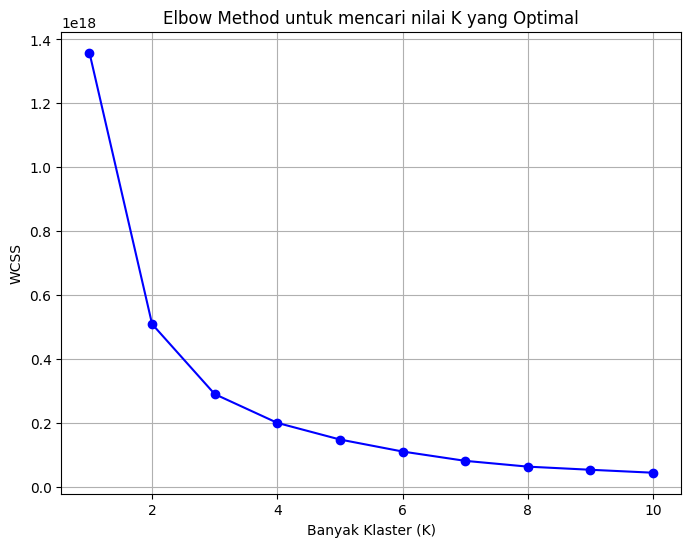

In [11]:
from sklearn.cluster import KMeans

wcss = [] # Inisialisasi list untuk menyimpan nilai WCSS tiap kelompok
# Buat loop untuk melatih algoritma K-Means
for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init=10, random_state=0)
    model.fit(X)
    wcss.append(model.inertia_)
    
# Buat grafik Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method untuk mencari nilai K yang Optimal')
plt.xlabel('Banyak Klaster (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

### Melakukan Klasterisasi pada Dataset dengan jumlah cluster (K=3) dengan Centroid

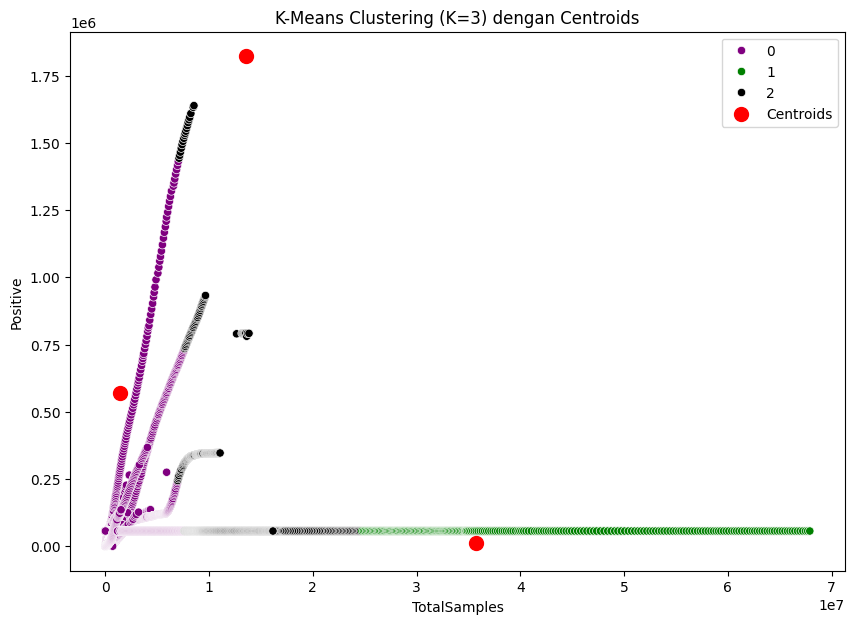

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Tentukan jumlah klaster
K = 3

# Inisialisasi dan latih K-Means
kmeans = KMeans(n_clusters=K, n_init=10)
kmeans.fit(X)

# Simpan label klaster dan centroids
df["cluster"] = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualisasikan klaster
warna = ["purple", "green", "black"]
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="TotalSamples", y="Positive", hue="cluster", palette=warna)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, label='Centroids')
plt.title(f"K-Means Clustering (K={K}) dengan Centroids")
plt.xlabel("TotalSamples")
plt.ylabel("Positive")
plt.legend()
plt.show()


### Evaluasi Cluster yang telah diprediksi dengan Unlabeled Dataset (Dataset Tanpa Label) menggunakan 3 metrik evaluasi

In [29]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
ss_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {ss_score:.2f}")
db_index = davies_bouldin_score(X, cluster_labels)
print(f"Davies-Bouldin Index: {db_index:.2f}")
ch_index = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.69
Davies-Bouldin Index: 0.60
Calinski-Harabasz Index: 30172.18


### Evaluasi Cluster yang telah diprediksi dengan Labeled Dataset (Dataset Tanpa Label) menggunakan 4 metrik evaluasi

In [40]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metris import homogeneity_score, completeness_score, v_measure_score

# Buat crosstab untuk membandingkan cluster labels dengan kolom Positive
cross_tab = pd.crosstab(df["cluster"], df["Positive"])
print("Cross-Tabulation:")
print(cross_tab, "\n")

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(df["Positive"], df["cluster"])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Normalized Mutual Information (NMI)
# Mengubah kolom Positive menjadi kategori numerik untuk evaluasi
positive_labels_num = df["Positive"].astype("category").cat.codes
nmi = normalized_mutual_info_score(positive_labels_num, df["cluster"])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Fungsi HCV-M
homogeneity = homogeneity_score(df["Positive"], df["cluster"])
completeness = completeness_score(df["Positive"], df["cluster"])
v_measure = v_measure_score(df["Positive"], df["cluster"])
print(f"Homogeneity Score: {homogeneity:.2f}")
print(f"Completeness Score: {completeness:.2f}")
print(f"V-Measure Score: {v_measure:.2f}")


Cross-Tabulation:
Positive  0.0        1.0        2.0        3.0        4.0        5.0        \
cluster                                                                      
0                77         83         61          8          4          3   
1                 0          0          0          0          0          0   
2                 0          0          0          0          0          0   

Positive  6.0        7.0        8.0        9.0        ...  1535315.0  \
cluster                                               ...              
0                 1         40          6          4  ...          0   
1                 0          0          0          0  ...          0   
2                 0          0          0          0  ...          1   

Positive  1543837.0  1554389.0  1564615.0  1576062.0  1586321.0  1595381.0  \
cluster                                                                      
0                 0          0          0          0          0          0

C:\Kuliah\Semester5\Praktikum\KecerdasanBuatan\venv_jupyterlab\Anhar\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Kuliah\Semester5\Praktikum\KecerdasanBuatan\venv_jupyterlab\Anhar\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Kuliah\Semester5\Praktikum\KecerdasanBuatan\venv_jupyterlab\Anhar\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Kuliah\Semester5\Praktikum\KecerdasanBuatan\venv_jupyterlab\Anhar\lib\site-packages\sklearn\metrics\cluster\_sup

### Visualiasi plot hasil clustering 

C:\Users\ACER\AppData\Local\Temp\ipykernel_6224\3561748532.py:5: UserWarning: 
The palette list has fewer values (3) than needed (4329) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df, x="TotalSamples", y="Positive", palette=warna,


TypeError: seaborn.utils._scatter_legend_artist() got multiple values for keyword argument 'label'

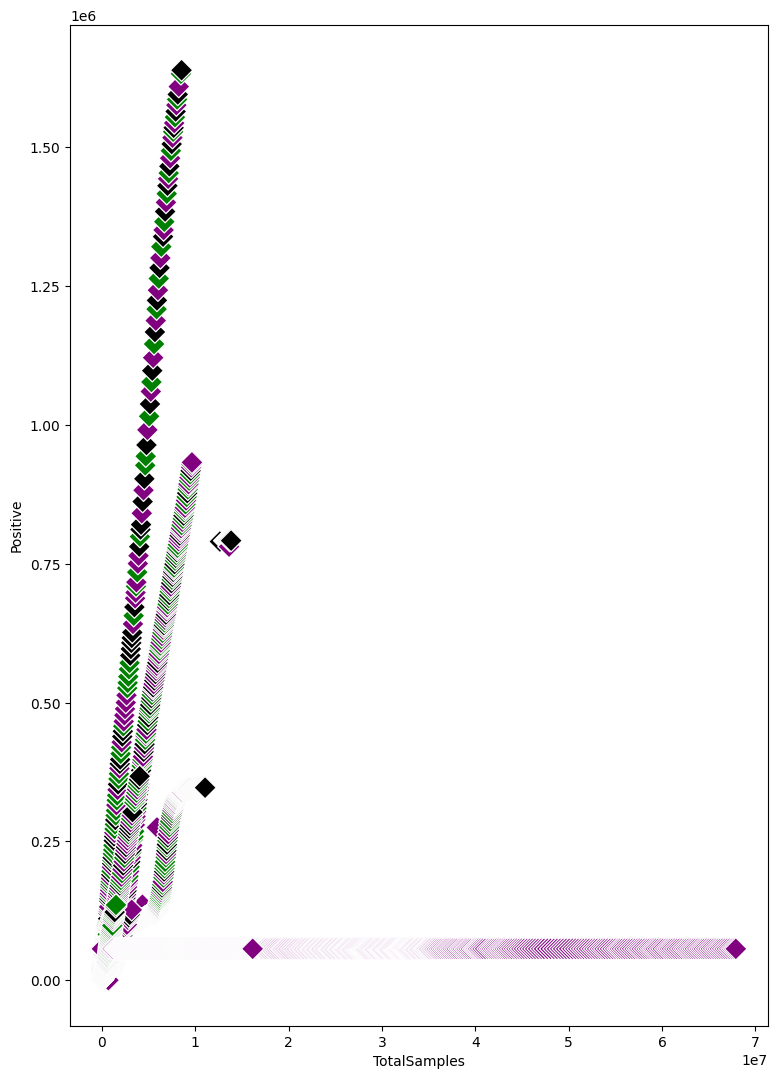

In [55]:
plt.figure(figsize=(9,13))
warna = ["purple", "green", "black"]

# Plot data asli dengan label asli
sns.scatterplot(data=df, x="TotalSamples", y="Positive", palette=warna,
                hue="Positive", marker="D", s=130, label="True Labels")

# Plot hasil klastering dengan warna berbeda
sns.scatterplot(data=df, x="TotalSamples", y="Positive", palette=warna,
                hue="cluster_mapped", marker="o", s=40, label="Clusters")

plt.title("K-Means Clustering dengan Label Asli")
plt.xlabel("TotalSamples")
plt.ylabel("Positive")
plt.legend(title="Legend", loc="upper right")
plt.show()
